In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
import numpy as np
import scipy as sp
import scipy.integrate
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
np.set_printoptions(linewidth=120)

In [481]:
directory = 'FullEqn_ivp_PS_5dom_R10p_L51p/'

In [12]:
#%%writefile FullEqn_ivp_PS_5dom_R10p_L51p/data.py

L, R = 100, 5
mesh_x = Multidomain(Legendre(15), np.linspace(0, L, 6))
#mesh_x = Legendre(71, (0, L))
mesh_r = Legendre(10, (R, 0), 'Radau')
mesh_phi = Constant()
mesh = mesh_x*mesh_r*mesh_phi

rho = 1.06; young = 3.7; nu = 0.34; l = -18.9; m = -13.3; n = -10.0 # PS
lam = young*nu/(1 + nu)/(1 - 2*nu)
mu = young/2/(1 + nu)

x_field, r_field, phi_field = TensorField(mesh, np.meshgrid(*mesh.grid(), indexing='ij'))
c = np.sqrt(young/rho)
def damp(t):
    data = 0.2*np.cos(np.pi*(x_field.func + 100)/L)**400
    return TensorField(mesh, data)

In [483]:
%run -i 'FullEqn_ivp_PS_5dom_R10p_L41p/data.py'

In [5]:
def cauchy_green(u):
    deform = u.grad(coord='cylindrical')
    return 1/2*(deform + deform.T + deform@deform.T)

def kin_energy(v):
    return rho*(v@v).int(coord='cylindrical')/2

def pot_energy(u):
    CG = cauchy_green(u)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    I3 = CG.det()
    pot = (lam/2 + mu)*I1**2 - 2*mu*I2 + (l + 2*m)/3*I1**3 - 2*m*I1*I2 + n*I3
    return pot.int(coord='cylindrical')

def energy(u, v):
    return kin_energy(v) + pot_energy(u)

In [6]:
def compress(u, v):
    return np.stack((u.func, v.func)).ravel()

def decompress(y):
    func_u, func_v = y.reshape(2, 3, *mesh.shape)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    return u, v

def derivative(t, y):
    u, v = decompress(y)
    du_dt = v
    
    CG = cauchy_green(u)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    dI1 = np.eye(3)
    dI2 = dI1*CG.trace() - CG
    dI3 = CG.cofactor_matrix()
    
    PK = (np.eye(3) + u.grad(coord='cylindrical'))@(
          (lam + 2*mu)*I1*dI1 - 2*mu*dI2 + (l + 2*m)*I1**2*dI1 
          - 2*m*(dI1*I2 + I1*dI2) + n*dI3)
    
    bval = (0, 0), (0, 0), (0, 0)
    F = PK.div(bval, coord='cylindrical')
    
    bval = (0, 0), (0, 0), (0, 0)
    #laplacian_v = (cauchy_green(v)).div(bval)
    #F -= damp(t)*v#laplacian_v
    
    F = F.match_domains()  
    
    dv_dt = F/rho
    
    return compress(du_dt, dv_dt)

# Initial condition 

In [13]:
%%time
width = 10
t0 = 0
t_max = 100.0
dt = 5.0
A0 = 0.01

T = np.arange(t0, t_max + dt/2, dt)
u_data = np.zeros((3,) + mesh.shape)
u_data[0] += -A0*width*sp.special.erf((x_field.func - L/2)/width)
u0 = TensorField(mesh, u_data)
u0[1] -= nu*r_field*u0[0].diff(0)
v0 = -c*u0.diff()

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
E = np.zeros(len(T))

r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

KeyboardInterrupt: 

In [485]:
np.save(directory + 'mesh_grid.npy', mesh.grid())
np.save(directory + 'displacement.npy', U.func)
np.save(directory + 'time.npy', T)
np.save(directory + 'energy.npy', E)

In [9]:
U_etalon = TensorField(mesh, U.func)

In [12]:
x_ref = np.linspace(0, L, 2000, endpoint=False) + L/2/2000
r_ref = np.linspace(0, R, 100, endpoint=False) + R/2/100

In [13]:
U_etal_norm = np.sqrt(np.sum(np.abs(U_etalon[-1, :](x_ref, r_ref, 0))**2))

In [14]:
U_etal_norm

171.5950462684692

In [10]:
err1 = []

In [16]:
for i in range(18, , 2):
    #mesh_x = Multidomain(Legendre(20), np.linspace(0, L, 21))
    mesh_x = Legendre(i, (0, L))
    mesh_r = Legendre(20, (R, 0), 'Radau')
    mesh_phi = Constant()
    mesh = mesh_x*mesh_r*mesh_phi
    x_field, r_field, phi_field = TensorField(mesh, np.meshgrid(*mesh.grid(), indexing='ij'))
    
    u_data = np.zeros((3,) + mesh.shape)
    u_data[0] += -A0*width*sp.special.erf((x_field.func - L/2)/width)
    u0 = TensorField(mesh, u_data)
    u0[1] -= nu*r_field*u0[0].diff(0)
    v0 = -c*u0.diff()

    U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
    V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
    E = np.zeros(len(T))

    r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
    r.set_initial_value(compress(u0, v0), t=t0)
    for k, t in enumerate(Progress(T)):
        if t > r.t:
            r.integrate(t)
        U[k], V[k] = decompress(r.y)
        E[k] = energy(U[k], V[k])
        
    diff2 = np.abs(U_etalon[-1, :](x_ref, r_ref, 0) - U[-1, :](x_ref, r_ref, 0))**2
    err1.append(np.sqrt(np.sum(diff2))/U_etal_norm)

HTML(value='')

In [19]:
np.sqrt(np.sum(diff2))

0.7029547359178951

In [17]:
err1

[0.004096591080013386]

In [380]:
fig, ax = plt.subplots(figsize=(8,5))
plt.xlim(0, L)
plt.ylim(-1, 2)
line, = ax.plot([], [])
line2, = ax.plot([], [])
time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'$x$')
plt.ylabel(r'$U_x(x, 0, 0)$')
plt.close()
x = np.linspace(0, L, 1000)

def animate(k):
    u = -U[k, 0](None, 0, 0).diff()/A0
    line.set_data(x, u(x + 0*T[k]))
    #line2.set_data(x, damp(T[k])(x + 0*T[k], 0, 0) - 0.5)
    time_text.set_text(time_template % T[k])
    return line, time_text

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=100, blit=True)

In [381]:
anim

In [209]:
x = np.linspace(0, L, 1000)

def soliton(x, X, A, L, B=0):
    return A/(B + np.cosh((x - X)/L)**2)

def fit(k, thr=0.7, optimize=True):
    u = -U[k, 0](None, 0, 0).diff()(x + c*T[k])
    i = u.argmax()
    X = x[i]
    A = u[i]
    L = np.trapz((u > thr*A).astype(float), x)/2/np.arccosh(1/np.sqrt(thr))
    if optimize:
        mask = (x > X - 2*L)*(x < X + 2*L)
        X, A, L = sp.optimize.curve_fit(soliton, x[mask], u[mask], (X, A, L))[0]
    return X, A, L
    
Xs, As, Ls = np.transpose([fit(k) for k in Progress(len(T))])

HTML(value='')

TypeError: Improper input: N=3 must not exceed M=0

0.005427971286357652

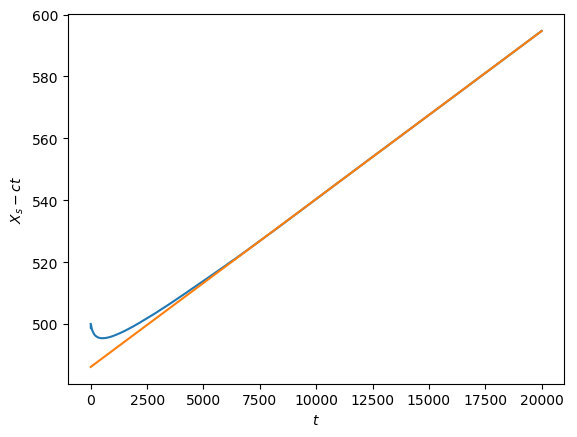

In [158]:
dv_num, X0 = np.polyfit(T[T > t_max/2], Xs[T > t_max/2], 1)
plt.plot(T, Xs)
plt.plot(T, X0 + dv_num*T)
plt.xlabel('$t$')
plt.ylabel('$X_s - ct$')
dv_num

In [159]:
beta1 = 3*young + 2*l*(1-2*nu)**3 + 4*m*(1+nu)**2*(1-2*nu) + 6*n*nu**2
v = c + dv_num
A_th = -3*rho*(v**2 - c**2)/beta1
L_th = v*nu*R*np.sqrt(2/(v**2 - c**2))
A_th

0.002336624964944028

0.0026014018622302075

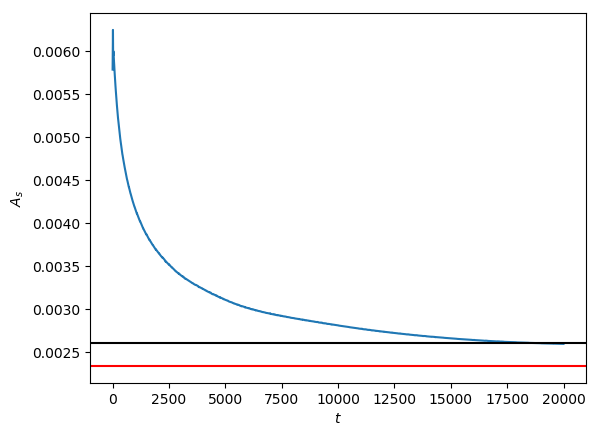

In [160]:
A_num = np.mean(As[T > 0.9*t_max])
plt.plot(T, As)
plt.axhline(A_num, c='k')
plt.axhline(A_th, c='r')
plt.xlabel('$t$')
plt.ylabel('$A_s$')
A_num

57.33444212626433

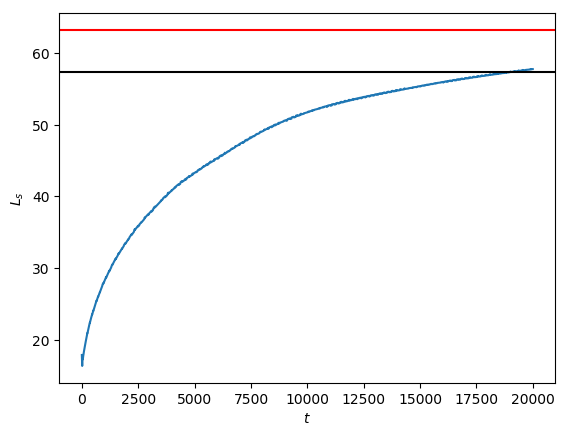

In [161]:
L_num = np.mean(Ls[T > 0.9*t_max])
plt.plot(T, Ls)
plt.axhline(L_num, c='k')
plt.axhline(L_th, c='r')
plt.xlabel('$t$')
plt.ylabel('$L_s$')
L_num

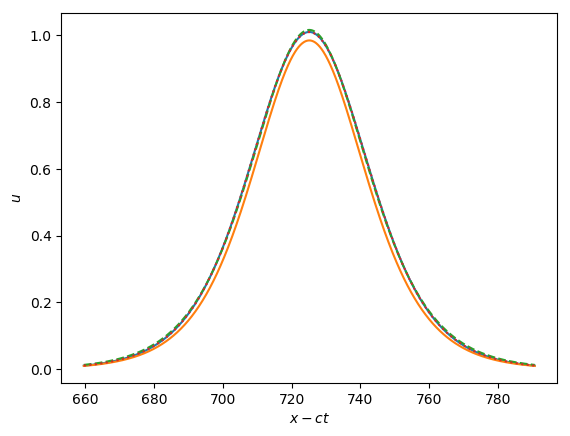

In [148]:
k = -1
x = np.linspace(X0 + (v - c)*T[k] - 3*L_th, X0 + (v - c)*T[k] + 3*L_th, 1000)
u = -U[k, 0](None, 0, 0).diff()/A0
plt.xlabel(r'$x - ct$')
plt.ylabel(r'$u$')
plt.plot(x, u(x + c*T[k]))
plt.plot(x, soliton(x, X0 + (v - c)*T[k], A_th, L_th)/A0)

XAL = sp.optimize.curve_fit(soliton, x, u(x + c*T[k]), (X0 + (v - c)*T[k], A_th, L_th))[0]
XALB = sp.optimize.curve_fit(soliton, x, u(x + c*T[k]), (X0 + (v - c)*T[k], A_th, L_th, 0))[0]
plt.plot(x, soliton(x, *XAL), '--')
plt.plot(x, soliton(x, *XALB), ':')

In [149]:
XAL

array([725.12616928,   1.01577553, -22.76212278])

In [150]:
XALB

array([ 7.25126147e+02,  1.20041430e+00, -2.15238387e+01,  1.89277203e-01])

In [151]:
fig, ax = plt.subplots(figsize=(16,6))
plt.xlim(0, L)
plt.ylim(-1, 2)
line, = ax.plot([], [])
line2, = ax.plot([], [])
time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.close()
p = Progress(len(T))
def animate(k):
    p.update()
    u = -U[k, 0](None, 0, 0).diff()/A0
    x = np.linspace(0, L, 1000)
    line.set_data(x, u(x + c*T[k]))
    line2.set_data(x, soliton(x, X0 + (v - c)*T[k], A_th, L_th)/A0)
    time_text.set_text(time_template % T[k])
    return line, line2, time_text

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=20, blit=True)

HTML(value='')

In [87]:
anim